In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 데이터분석 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib as mpl
import os
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import math
from sklearn.model_selection import StratifiedKFold as kfold
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


import lightgbm as lgb
# from sklearn.model_selection import StratifiedKFold as kfold
# from sklearn.ensemble import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures







# plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'NanumGothic'
plt.rc("font", family="Malgun Gothic")
plt.rc('font', family='NanumBarunGothic') 

import warnings
warnings.filterwarnings('ignore')

In [4]:
# 유방암 데이터 불러오기
base_path = "/content/drive/MyDrive/Colab Notebooks/유방암 이미지 분류_프로젝트/"

train_df = pd.read_csv(base_path + "train_cancer.csv")
test_df = pd.read_csv(base_path + "test_cancer.csv")

In [ ]:
train_df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   site_id        4 non-null      int64 
 1   patient_id     4 non-null      int64 
 2   image_id       4 non-null      int64 
 3   laterality     4 non-null      object
 4   view           4 non-null      object
 5   age            4 non-null      int64 
 6   implant        4 non-null      int64 
 7   machine_id     4 non-null      int64 
 8   prediction_id  4 non-null      object
dtypes: int64(6), object(3)
memory usage: 416.0+ bytes


In [5]:
train_df["age"] = train_df["age"].fillna(0)

In [6]:
# 범주형 변수 인코딩
# label encoding
str_col = ['laterality', 'view', 'difficult_negative_case']
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train_df[i])
    train_df[i]=le.transform(train_df[i])
    
    # for label in np.unique(test[i]):
    #     if label not in le.classes_: 
    #         le.classes_ = np.append(le.classes_, label)
    # test[i]=le.transform(test[i])

In [7]:
str_col = ['laterality', 'view']
for i in str_col:
    le = LabelEncoder()
    le=le.fit(test_df[i])
    test_df[i]=le.transform(test_df[i])

In [ ]:
# # onehot_encoding
# train = pd.get_dummies(train, columns = str_col[1:], drop_first=False)
# test = pd.get_dummies(test, columns = str_col[1:], drop_first=False)


In [8]:
# 변수 선택
y_train = train_df["cancer"]

X_train = train_df.drop(['biopsy', 'invasive', 'BIRADS', 'density', 'machine_id', 'cancer'], axis=1)

X_test = test_df.drop('prediction_id', axis=1)



In [9]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_train.loc[:, :] = scaler.transform(X_train)
# X_test.loc[:, :] = scaler.transform(X_test)


print(X_train)
print(X_test)

        site_id  patient_id  image_id  laterality      view       age  \
0      1.082586   -1.201082 -0.997157   -1.003149 -1.020386  0.245588   
1      1.082586   -1.201082  0.614819   -1.003149  0.979855  0.245588   
2      1.082586   -1.201082  1.269898    0.996861  0.979855  0.245588   
3      1.082586   -1.201082  1.286646    0.996861 -1.020386  0.245588   
4      1.082586   -1.200817 -1.389263   -1.003149 -1.020386 -0.344846   
...         ...         ...       ...         ...       ...       ...   
54701 -0.923714   -1.202828  1.051458    0.996861  0.979855 -1.525714   
54702 -0.923714   -1.201982 -1.643017   -1.003149  0.979855  0.147182   
54703 -0.923714   -1.201982 -0.000716   -1.003149 -1.020386  0.147182   
54704 -0.923714   -1.201982 -1.101931    0.996861  0.979855  0.147182   
54705 -0.923714   -1.201982 -1.034397    0.996861 -1.020386  0.147182   

        implant  difficult_negative_case  
0     -0.166577                -0.404886  
1     -0.166577                -0.404

In [10]:
# Train-Test Split

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, 
                                            stratify=train_df['patient_id'], random_state=2023)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(38294, 8) (38294,)
(16412, 8) (16412,)


## Xgboost

In [ ]:
# xgboost 모델
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_estimators=10000, 
                              max_depth=5, 
                              subsample=0.3,
                              colsample_bytree=0.5,
                              reg_lambda=15,
                              random_state=20)


xgb_model.fit(X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='mae',
                verbose=100,
                early_stopping_rounds=200)    


from sklearn.metrics import mean_absolute_error
print(f"훈련 셋: {mean_absolute_error(y_train, xgb_model.predict(X_train))}")
print(f"검증 셋: {mean_absolute_error(y_val, xgb_model.predict(X_val))}")

[0]	validation_0-mae:0.454669
Will train until validation_0-mae hasn't improved in 200 rounds.
[100]	validation_0-mae:0.040831
[200]	validation_0-mae:0.040383
[300]	validation_0-mae:0.040388
[400]	validation_0-mae:0.040294
[500]	validation_0-mae:0.040203
[600]	validation_0-mae:0.039698
[700]	validation_0-mae:0.04001
[800]	validation_0-mae:0.039913
[900]	validation_0-mae:0.039582
[1000]	validation_0-mae:0.039678
Stopping. Best iteration:
[846]	validation_0-mae:0.039051

훈련 셋: 0.020995456207238732
검증 셋: 0.021508652205703145


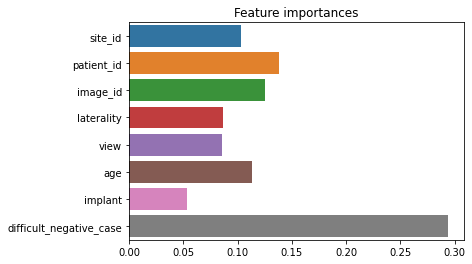

In [ ]:
# Xgboost 의 피처 중요도
feature_names = X_train.columns
importances = xgb_model.feature_importances_
sns.barplot(y=feature_names, x=importances, estimator=np.mean)
plt.title("Feature importances")
plt.show()

In [ ]:
# xgb 추론
pred1 = xgb_model.predict(X_val)
len(pred1)

16412

In [ ]:
#xgb submission 예비형식
sub1 = submission.copy()
sub1['target'] = pred  

## LightGBM

In [ ]:
# LightGBM
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(n_estimators=10000, 
                              num_leaves = 128, 
                              subsample=0.6,
                              colsample_bytree=0.7,
                              reg_lambda=15,
                              random_state=20)


lgb_model.fit(X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='l1',
                verbose=500,
                early_stopping_rounds=100)    


from sklearn.metrics import mean_absolute_error
print(f"훈련 셋: {mean_absolute_error(y_train, lgb_model.predict(X_train))}")
print(f"검증 셋: {mean_absolute_error(y_val, lgb_model.predict(X_val))}")

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's binary_logloss: 0.0877187	valid_0's l1: 0.0361294
Early stopping, best iteration is:
[466]	valid_0's binary_logloss: 0.0874966	valid_0's l1: 0.0363255
훈련 셋: 0.017078393482007626
검증 셋: 0.021935169388252497


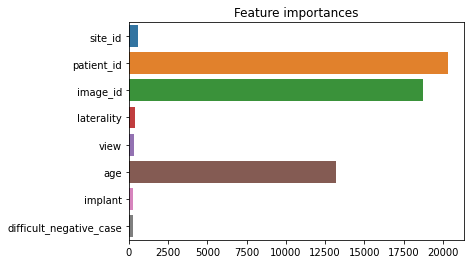

In [ ]:
#lgb_feature importance
feature_names = X_train.columns
importances = lgb_model.feature_importances_
sns.barplot(y=feature_names, x=importances, estimator=np.mean)
plt.title("Feature importances")
plt.show()

In [ ]:
#lgb_추론
pred2 = lgb_model.predict(X_val)
len(pred2)

16412

In [ ]:
#lgb submission 예비형식
sub2 = submission.copy()
sub2['target'] = pred2  

In [14]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.7 MB/s eta 0:00:00


In [21]:
# catboost 모델1

# from sklearn.model_selection import train_test_split
# X_train, X_val,y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=20)

from catboost import CatBoostClassifier
from tqdm import tqdm


clf = CatBoostClassifier(
    iterations=10000, 
    learning_rate=0.1, 
    loss_function='CrossEntropy')



In [ ]:
tqdm(clf.fit(X_train, y_train, 
        eval_set=(X_val, y_val), 
        verbose=False))

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

In [ ]:
# catboost 모델2
from catboost import CatBoostClassifier
clf = CatBoostClassifier(iterations=10000, learning_rate=0.01, l2_leaf_reg=3.5, depth=8, rsm=0.98, loss_function= 'Logloss', eval_metric='AUC',use_best_model=True,random_seed=42)

clf.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5005:	test: 0.7837085	best: 0.7837695 (5002)	total: 2m 3s	remaining: 2m 2s
5006:	test: 0.7836899	best: 0.7837695 (5002)	total: 2m 3s	remaining: 2m 2s
5007:	test: 0.7836902	best: 0.7837695 (5002)	total: 2m 3s	remaining: 2m 2s
5008:	test: 0.7836802	best: 0.7837695 (5002)	total: 2m 3s	remaining: 2m 2s
5009:	test: 0.7836681	best: 0.7837695 (5002)	total: 2m 3s	remaining: 2m 2s
5010:	test: 0.7836301	best: 0.7837695 (5002)	total: 2m 3s	remaining: 2m 2s
5011:	test: 0.7836186	best: 0.7837695 (5002)	total: 2m 3s	remaining: 2m 2s
5012:	test: 0.7836384	best: 0.7837695 (5002)	total: 2m 3s	remaining: 2m 2s
5013:	test: 0.7836030	best: 0.7837695 (5002)	total: 2m 3s	remaining: 2m 2s
5014:	test: 0.7836087	best: 0.7837695 (5002)	total: 2m 3s	remaining: 2m 2s
5015:	test: 0.7836220	best: 0.7837695 (5002)	total: 2m 3s	remaining: 2m 2s
5016:	test: 0.7836598	best: 0.7837695 (5002)	total: 2m 3s	remaining: 2m 2s
5017:	test: 0.7836828	best: 0.7837695 (5002)	total: 2m 3s	remain

In [ ]:
print(clf.predict(data=X_val))

[0 0 0 ... 0 0 0]


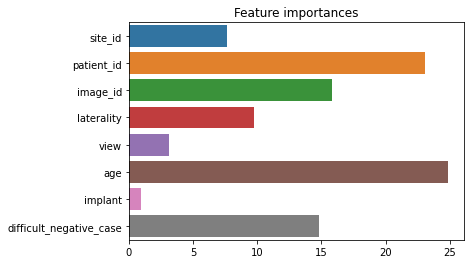

In [ ]:
# catboost 피처중요도
feature_names = X_train.columns
importances = clf.feature_importances_
sns.barplot(y=feature_names, x=importances, estimator=np.mean)
plt.title("Feature importances")
plt.show()

In [ ]:
#cat 추론
pred3 = clf.predict_proba(X_val)
len(pred3)


16412

In [ ]:
#catboost submission 예비형식
sub3 = submission.copy()
sub3['target'] = pred3 

In [ ]:
# #Ensemble
# submission['target'] = np.round((sub1['target'] + sub2['target'] + sub3['target']) / 3)
# submission.to_csv("./final_submission2.csv", index = False)

In [ ]:
submission['target'] = sub3['target']
submission.to_csv("./final_submission4.csv", index = False)  

In [ ]:
print("Prediction")
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_val)

train_score = evaluation_metric(y_train, pred_train)
test_score = evaluation_metric(y_val, pred_test)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % test_score)

In [ ]:
# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna


def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    iterations = trial.suggest_int('iterations', 1000, 5000)
    depth = trial.suggest_int('depth', 3, 5)  # 범위
    # max_features = trial.suggest_float('max_features', 0.7, 0.9)

    
    
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = cb.CatBoostClassification(iterations=iterations,
                                 depth=depth)
    
    
    # K-Fold Cross validation을 구현합니다.
    from sklearn.model_selection import StratifiedKFold
    folds = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in folds.split(X_train, y_train):
        X_train2 = X_train.iloc[train_idx, :]
        y_train2 = y_train.iloc[train_idx]
        
        X_val2 = X_train.iloc[val_idx, :]
        y_val2 = y_train.iloc[val_idx]
        
        model.fit(X_train2, y_train2)
        preds = model.predict(X_val2)
        score = evaluation_metric(y_val2, preds)
        scores.append(score)
    
    del model
    gc.collect()
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(scores)